In [1]:
from vnpy.trader.app.ctaStrategy import BacktestingEngine

# 创建回测引擎对象
engine = BacktestingEngine()

# 设置回测使用的数据
engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
engine.setDatabase('VnTrader_1Min_Db')  # 设置使用的历史数据库
engine.setStartDate('20180515 12:00',initHours=200) # 设置回测用的数据起始日期
engine.setEndDate('20181123 12:00') # 设置回测用的数据终止日期

# 配置回测引擎参数
engine.setSlippage(0.002)    # 设置滑点
engine.setRate(5/10000)   # 设置手续费千1
engine.setCapital(100000)  # 设置回测本金

In [ ]:
from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta

In [2]:
# 策略继承CtaTemplate
class RSIMACDStrategy(CtaTemplate):
    className = 'RSIMACDStrategy'
    author = 'Yingxiao'
    
    # 策略参数
    amWindow = 20
    macdfastPeriod = 12; macdslowPeriod = 26; macdsignalPeriod = 9
    rsishortPeriod = 6; rsilongPeriod = 12
    trailingPct = 0.04
    lot = 1
    
    # 策略变量
    transactionPrice = {} # 记录成交价格
    intraTradeHighDict = {}; intraTradeLowDict = {}
    macd = {}
    
    # 参数列表，保存了参数的名称
    paramList = [
                 'amWindow',
                 "macdfastPeriod" , "macdslowPeriod", "macdsignalPeriod"
                 "rsishortPeriod" , "rsilongPeriod"
                ]  
    
    # 变量列表，保存了变量的名称
    varList = ['transactionPrice',
               'intraTradeHighDict', 'intraTradeLowDict',
               'macd'
              ] 
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']
    
    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        super().__init__(ctaEngine, setting)
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList}
        self.intraTradeHighDict = {s:0 for s in self.symbolList}
        self.intraTradeLowDict = {s:999999 for s in self.symbolList}
        self.macd = {s:0 for s in self.symbolList}
        self.putEvent()
    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
        symbol = bar.vtSymbol
        
        # 洗价器（止盈止损）
        if self.posDict[symbol+'_LONG'] == 0 and self.posDict[symbol+'_SHORT'] == 0:
            self.intraTradeHighDict[symbol] = 0
            self.intraTradeLowDict[symbol] = 999999
        # 持有多头仓位
        elif self.posDict[symbol+'_LONG'] >0:
            self.intraTradeHighDict[symbol] = max(self.intraTradeHighDict[symbol], bar.high)
            self.longStop = self.intraTradeHighDict[symbol]*(1-self.trailingPct)
            if bar.close<=self.longStop:
                self.cancelAll()
                self.sell(symbol, bar.close*0.9, self.posDict[symbol+'_LONG'])
#         # 持有空头仓位
        elif self.posDict[symbol+'_SHORT'] >0:
            self.intraTradeLowDict[symbol] = min(self.intraTradeLowDict[symbol], bar.low)
            self.shortStop = self.intraTradeLowDict[symbol]*(1+self.trailingPct)
            if bar.close>=self.shortStop:
                self.cancelAll()
                self.cover(symbol, bar.close*1.1, self.posDict[symbol+'_SHORT'])
        self.putEvent()
    #----------------------------------------------------------------------
    
    def on60MinBar(self, bar):
        """收到60MinBar推送"""
        symbol = bar.vtSymbol
        am60 = self.getArrayManager(symbol, "60m")
        if not am60.inited:
            return
        # 计算均线并判断趋势
        diff = ta.EMA(am60.close,self.macdfastPeriod) - ta.EMA(am60.close,self.macdslowPeriod)
        dea = ta.EMA(diff,self.macdsignalPeriod)
        macd = (diff - dea) * 2
        
        if (macd[-1]>macd[-2]>macd[-3]>macd[-4]):
            self.macd[symbol] = 1
        elif (macd[-2]>0) and (macd[-1]<=0):
            self.macd[symbol] = -1
        self.putEvent()    
        Signal=self.WVAD[symbol]   
        if ma6wvad[-1]>ma24wvad[-1] and (self.posDict[symbol+'_LONG']==0):
            if self.posDict[symbol+'_SHORT']==0:
                self.buy(symbol,bar.close*1.02, self.lot)
            elif self.posDict[symbol+'_SHORT'] > 0:
                self.cancelAll()
                self.cover(symbol,bar.close*1.1, self.posDict[symbol+'_SHORT'])
                self.buy(symbol,bar.close*1.1, self.lot)
        elif ma6wvad[-1]<ma24wvad[-1] and (self.posDict[symbol+'_SHORT']==0):
            if (self.posDict[symbol+'_LONG']==0):
                self.short(symbol,bar.close*0.9, self.lot)
            elif self.posDict[symbol+'_LONG']>0:
                self.cancelAll()
                self.sell(symbol,bar.close*0.98, self.posDict[symbol+'_LONG'])
                self.short(symbol,bar.close*0.98, self.lot)
        self.putEvent()
   
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        # 对于无需做交易信息记录的策略，可以忽略onTrade
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
#             print(trade.tradeTime, self.posDict)
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [3]:
if __name__=="__main__":
    from vnpy.trader.app.ctaStrategy import BacktestingEngine
    # 创建回测引擎对象
    engine = BacktestingEngine()
    # 设置回测使用的数据
    engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
    engine.setDatabase('VnTrader_1Min_Db')  # 设置使用的历史数据库
    engine.setStartDate('20180515 12:00',initHours=200) # 设置回测用的数据起始日期
    engine.setEndDate('20181123 12:00') # 设置回测用的数据终止日期
    # 配置回测引擎参数
    engine.setSlippage(0.002)    # 设置滑点
    engine.setRate(5/10000)   # 设置手续费千1
    engine.setCapital(1000000)  # 设置回测本金
    # # 在引擎中创建策略对象
    parameterDict = {'symbolList':['BTCUSDT:binance']}          # 策略参数配置
    engine.initStrategy(RSIMACDStrategy, parameterDict)    # 创建策略对象
    engine.runBacktesting()

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function RSIMACDStrategy.on60MinBar at 0x0000020BA244ED08>, <__main__.RSIMACDStrategy object at 0x0000020BA2442400>)
[DEBUG] 注册品种BTCUSDT:binance上的on_5Min_bar函数functools.partial(<function RSIMACDStrategy.on5MinBar at 0x0000020BA244E1E0>, <__main__.RSIMACDStrategy object at 0x0000020BA2442400>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function RSIMACDStrategy.onBar at 0x0000020BA244EB70>, <__main__.RSIMACDStrategy object at 0x0000020BA2442400>)
2018-12-04 23:33:36.886209	开始回测
2018-12-04 23:33:36.886209	策略初始化
2018-12-04 23:33:36.888200	载入历史数据。数据范围:[20180507 04:00,20180515 12:00)
2018-12-04 23:33:37.440176	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-04 23:33:37.442210	载入完成，数据量：12000
2018-12-04 23:33:37.442210	策略初始化完成
2018-12-04 23:33:37.443167	策略启动完成
2018-12-04 23:33:37.443167	开始回放回测数据,回测范围:[20180515 12:00,20181123 12:00)
2018-12-04 23:33:3

2018-12-04 23:34:22.090204	计算按日统计结果
2018-12-04 23:34:22.139071	------------------------------
2018-12-04 23:34:22.139071	首个交易日：	2018-05-15 00:00:00
2018-12-04 23:34:22.139071	最后交易日：	2018-11-23 00:00:00
2018-12-04 23:34:22.139071	总交易日：	193
2018-12-04 23:34:22.139071	盈利交易日	93
2018-12-04 23:34:22.139071	亏损交易日：	98
2018-12-04 23:34:22.139071	起始资金：	100000
2018-12-04 23:34:22.139071	结束资金：	103,217.32
2018-12-04 23:34:22.140069	总收益率：	3.22%
2018-12-04 23:34:22.140069	年化收益：	4.0%
2018-12-04 23:34:22.140069	总盈亏：	3,217.32
2018-12-04 23:34:22.140069	最大回撤: 	-1,335.81
2018-12-04 23:34:22.140069	百分比最大回撤: -1.31%
2018-12-04 23:34:22.140069	总手续费：	1,638.75
2018-12-04 23:34:22.140069	总滑点：	0.96
2018-12-04 23:34:22.140069	总成交金额：	3,277,494.03
2018-12-04 23:34:22.140069	总成交笔数：	482
2018-12-04 23:34:22.140069	日均盈亏：	16.67
2018-12-04 23:34:22.140069	日均手续费：	8.49
2018-12-04 23:34:22.140069	日均滑点：	0.0
2018-12-04 23:34:22.140069	日均成交金额：	16,981.83
2018-12-04 23:34:22.140069	日均成交笔数：	2.5
2018-12-04 23:34:22.140069	日均收益率：	0.

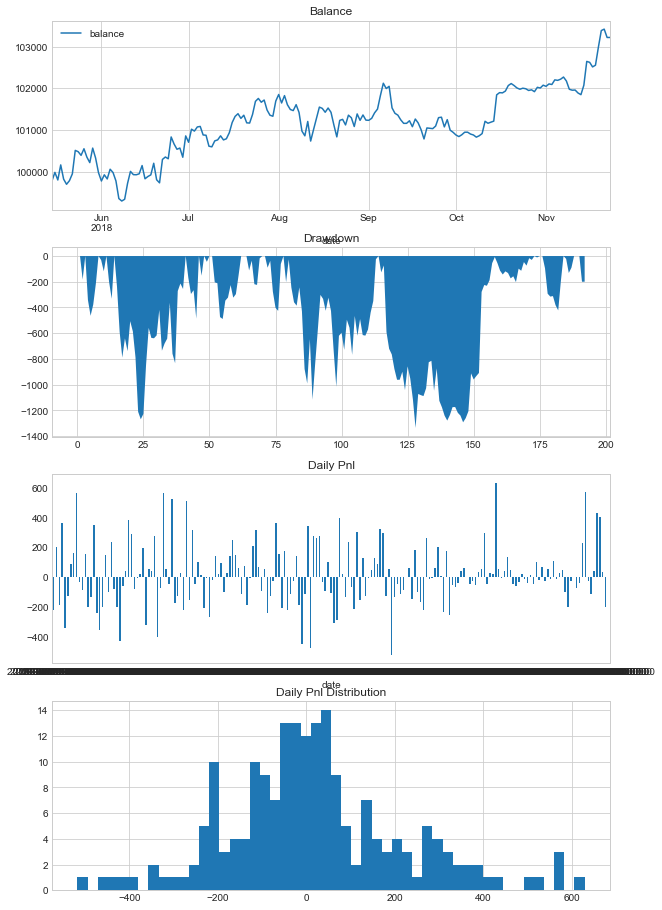

In [5]:
# 显示逐日回测结果
engine.showDailyResult()

2018-12-04 23:34:26.846126	计算回测结果
2018-12-04 23:34:26.886014	------------------------------
2018-12-04 23:34:26.886014	第一笔交易：	2018-05-16 02:07:00
2018-12-04 23:34:26.886014	最后一笔交易：	2018-11-22 19:33:00
2018-12-04 23:34:26.886014	总交易次数：	241
2018-12-04 23:34:26.886014	总盈亏：	3,217.32
2018-12-04 23:34:26.886014	最大回撤: 	-1,335.1
2018-12-04 23:34:26.886014	平均每笔盈利：	13.35
2018-12-04 23:34:26.886014	平均每笔滑点：	0.0
2018-12-04 23:34:26.886014	平均每笔佣金：	6.8
2018-12-04 23:34:26.886014	胜率		35.27%
2018-12-04 23:34:26.886014	盈利交易平均值	175.4
2018-12-04 23:34:26.886014	亏损交易平均值	-74.95
2018-12-04 23:34:26.886014	盈亏比：	2.34


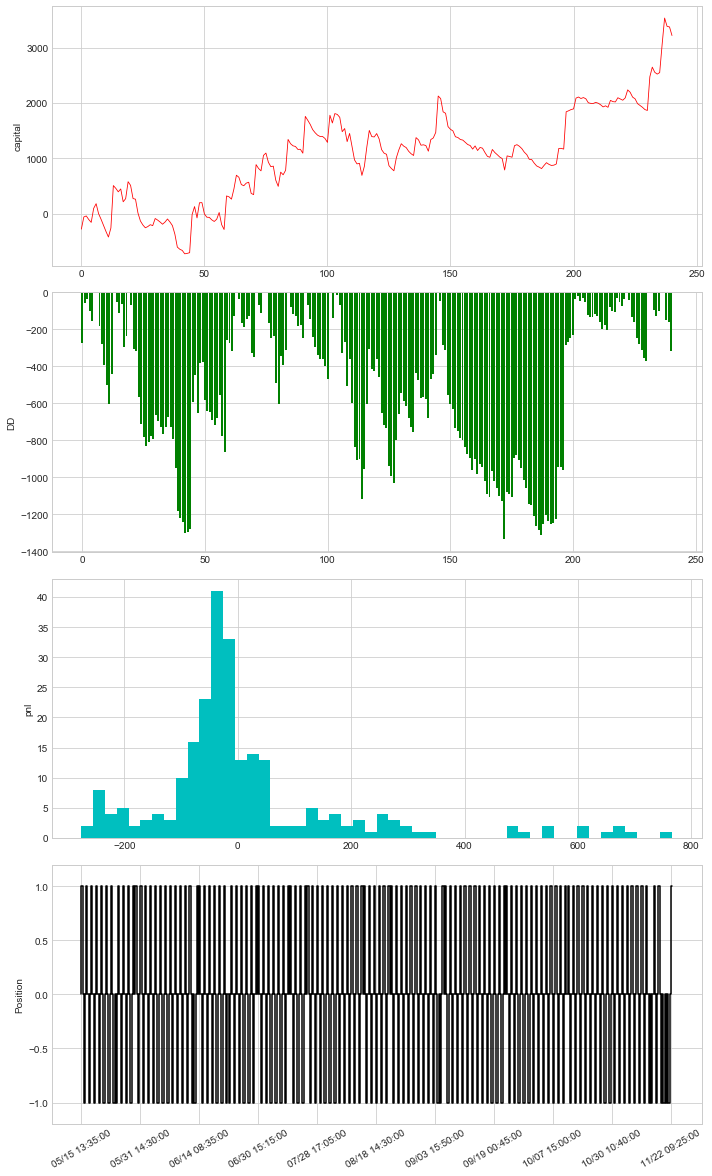

In [6]:
# 显示逐笔回测结果
engine.showBacktestingResult()

In [ ]:
import pandas as pd
tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
tradeDf = tradeReport.set_index('dt')
tradeDf.tail()

In [ ]:
from vnpy.trader.app.ctaStrategy.ctaBacktesting  import OptimizationSetting
# 优化配置
setting = OptimizationSetting()                # 新建一个优化任务设置对象
setting.setOptimizeTarget('sharpeRatio')        # 设置优化排序的目标是夏普
setting.addParameter('macdfastPeriod', 9, 18, 1)    # 增加第一个优化参数，起始9，结束18，步进3
setting.addParameter('macdslowPeriod', 20, 40, 1)    # 增加第二个优化参数，起始20，结束38，步进6
# setting.addParameter('signalPeriod', 20, 30, 2)

# setting.addParameter('signalMaPeriod', 10, 20, 5)    # 增加第二个优化参数，起始10，结束30，步进5

setting.addParameter('symbolList', ['BTCUSDT:binance']) 

In [ ]:
import time
start = time.time()
# 执行单线程优化
resultList = engine.runOptimization(RSIMACDStrategy, setting)
# 执行多进程优化一般会改写成py文件然后用多线程运行，提高优化速度。
# resultList = engine.runParallelOptimization(MultiFrameMaStrategy, setting)
print('耗时：%s' %(time.time()-start))

In [ ]:
import pandas as pd
print(pd.DataFrame(resultList).sort_values(1, ascending=False))

In [ ]:
# 显示优化的所有统计数据
for result in resultList:
    print('-' * 30)
    print('参数：%s，目标：%s' %(result[0], result[1]))
    print('统计数据：')
    for k, v in result[2].items():
        print('%s：%s' %(k, v))